<a href="https://colab.research.google.com/github/AmbiTyga/Task-Stylumia/blob/Basic/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Kaggle Download
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c stumbleupon

Saving kaggle.json to kaggle.json
  0% 0.00/21.5k [00:00<?, ?B/s]
100% 21.5k/21.5k [00:00<00:00, 40.1MB/s]
 97% 153M/157M [00:12<00:00, 9.05MB/s]
100% 157M/157M [00:12<00:00, 13.2MB/s]
100% 8.02M/8.02M [00:02<00:00, 3.50MB/s]

  0% 0.00/3.45M [00:00<?, ?B/s]
100% 3.45M/3.45M [00:00<00:00, 114MB/s]


In [ ]:
!unzip -q /content/raw_content.zip

In [65]:
!git clone https://github.com/misja/python-boilerpipe.git
%cd python-boilerpipe
!pip install -r requirements.txt -q
!python setup.py install -q
%cd ..

Cloning into 'python-boilerpipe'...
remote: Enumerating objects: 264, done.
remote: Total 264 (delta 0), reused 0 (delta 0), pack-reused 264
Receiving objects: 100% (264/264), 30.06 KiB | 831.00 KiB/s, done.
Resolving deltas: 100% (91/91), done.
/content/python-boilerpipe
     |████████████████████████████████| 460kB 5.7MB/s 
/usr/lib/python3.7/distutils/dist.py:274: UserWarning: Unknown distribution option: 'install_requires'
  warnings.warn(msg)
running install
running build
running build_py
creating build
creating build/lib
creating build/lib/boilerpipe
copying src/boilerpipe/__init__.py -> build/lib/boilerpipe
creating build/lib/boilerpipe/extract
copying src/boilerpipe/extract/__init__.py -> build/lib/boilerpipe/extract
creating build/lib/boilerpipe/data
creating build/lib/boilerpipe/data/boilerpipe-1.2.0
copying src/boilerpipe/data/boilerpipe-1.2.0/boilerpipe-1.2.0.jar -> build/lib/boilerpipe/data/boilerpipe-1.2.0
creating build/lib/boilerpipe/data/boilerpipe-1.2.0/lib
copying sr

In [66]:
import pandas as pd 
import numpy as np
import json
from bs4 import BeautifulSoup
import re, operator
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from boilerpipe.extract import Extractor
from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder

## Preprocessing Functions

In [67]:
def extract_domain(df_url):
    # extract domains
    domain = df_url.str.lower().apply(lambda x:x.split('/')[2])
    domain_parts = domain.str.split('.')

    return domain_parts.apply(lambda x:'.'.join(x[-2:]) if x[-2] not in ['com', 'co'] else '.'.join(x[-3:]))

In [68]:
def clean_string(s):
  s = re.sub(r'[\r\n\t]', ' ',s)
  s = re.sub(r"\s+", ' ', s)
  return s.strip()

In [69]:
def boil_soup(urlid):
    filename = '/content/raw_content/' + urlid

    with open(filename, 'rb') as f:
        html = f.read()

        for parser in ["lxml", "xml", "html5lib"]:
            soup = BeautifulSoup(html, parser)
            if soup.body:
                return soup

        return BeautifulSoup(html)

In [70]:
def get_title(id):
  
  TAGS_REMOVE = ['script', 'style']
  
  soup = boil_soup(id)


  for el in soup.find_all(TAGS_REMOVE):
    el.extract()
  
  texts = soup.find_all('title')
  texts = [clean_string(x.text) for x in texts]

  try:
    return texts[np.argmax([len(x.split()) for x in texts])]
  except ValueError:
    return np.nan

In [190]:
def padding(text,attr = 'title'):
  max_len = 39 if attr=='title' else 282
  sent_len = len(text.split())
  if sent_len>max_len:
    return " ".join(text.split()[:max_len])
  else:
    text = " ".join(text.split()+['<pad>']*(max_len-sent_len))
    return text

## Dataset

In [ ]:
data = pd.concat([pd.read_csv('/content/train.tsv.zip',sep = '\t'),
                  pd.read_csv('/content/test.tsv.zip',sep = '\t')],ignore_index = True)

In [ ]:
item = data.copy()

## Feature Extraction

In [ ]:
item['real_url'] = item['url'].str.lower()
item['domain'] = extract_domain(item['real_url'])
item['tld'] = item['domain'].str.split('.').apply(lambda x:x[-1])

In [ ]:
item['body'] = item['boilerplate'].apply(lambda x:json.loads(x)['body'])
item.rename(columns = {'url':'org_url'},inplace = True)

item.drop(columns = ['boilerplate'],inplace = True)

In [ ]:
item['title'] = item['urlid'].astype(str).apply(get_title)

In [ ]:
item['alchemy_category_score'].replace('?','0.0',inplace = True)
item['alchemy_category_score'] = item['alchemy_category_score'].apply(float)

In [ ]:
item['is_news'].replace('?','0',inplace = True)
item['is_news'] = item['is_news'].apply(int)

In [ ]:
train = item.dropna(subset=['label'])
test = item[item['label'].isna()]

In [ ]:
scaler1 = StandardScaler()
scaler1.fit(train['non_markup_alphanum_characters'].values.reshape(-1,1))
item['non_markup_alphanum_characters'] = scaler1.transform(item['non_markup_alphanum_characters'].values.reshape(-1,1))
scaler2 = StandardScaler()
scaler2.fit(train['numberOfLinks'].values.reshape(-1,1)) 
item['numberOfLinks'] = scaler2.transform(item['numberOfLinks'].values.reshape(-1,1))  
norm = Normalizer()
norm.fit(train['avglinksize'].values.reshape(-1,1)) 
item['avglinksize'] = norm.transform(item['avglinksize'].values.reshape(-1,1))  

In [ ]:
item['alchemy_category_score'] = item['alchemy_category_score'].replace('?',0).astype(float)
item['alchemy_category'].replace('?','',inplace = True)

In [ ]:
le = LabelEncoder()
item['alchemy_labels'] = le.fit_transform(item['alchemy_category'])

In [ ]:
final = item[['urlid','alchemy_category_score','alchemy_labels','avglinksize',
      'commonlinkratio_1','commonlinkratio_2',
      'commonlinkratio_3','commonlinkratio_4',
      'compression_ratio','embed_ratio',
      'frameTagRatio','hasDomainLink',
      'html_ratio','image_ratio','is_news',
      'lengthyLinkDomain','linkwordscore',
      ,'non_markup_alphanum_characters',
      'numberOfLinks','numwords_in_url',
      'parametrizedLinkRatio','spelling_errors_ratio',
      'tld','alchemy_category','title','body','label']]

In [206]:
final = pd.concat([pd.read_json('/content/train_parsed.json'),
                   pd.read_json('/content/test_parsed.json')],ignore_index = True)

In [207]:
final['title'].fillna('NULL',inplace = True)
final['body'].fillna('NULL',inplace = True)

In [208]:
final['title'].replace('','NULL',inplace = True)

In [209]:
final['title'] = final['title'].apply(lambda text:re.sub(r'[\W_]+',' ', text))
final['body'] = final['body'].apply(lambda text:re.sub(r'[\W_]+',' ', text))

final['body'] = final['body'].str.replace(r'[½]','half')
final['body'] = final['body'].str.replace('[¼]','quarter')

pattern = re.compile(r'[^a-zA-Z0-9\d\s:]')
final['body'] = final['body'].str.replace(pattern,' ')
final['alchemy_category'] = final['alchemy_category'].str.replace(pattern,' ')

In [210]:
final['text'] = '<tld> '+ final['tld']+ ' <ac> ' + final['alchemy_category'] + ' <title> ' + final['title'].apply(padding)+ ' <body> ' + final['body'].apply(padding,attr='body') 

In [211]:
final['raw_text'] = final['tld']+' '+final['alchemy_category']+' '+final['title']+' '+final['body']

In [212]:
pd.set_option('max_rows',12)

In [213]:
train = final.dropna(subset=['label']).reset_index(drop = True)
test = final[final['label'].isna()].drop(columns = ['label']).reset_index(drop = True)

In [214]:
train.to_json("/content/train_parsed.json",orient='records')
test.to_json("/content/test_parsed.json",orient='records')

In [216]:
!7z a TrainTest.7z test_parsed.json train_parsed.json


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive:
  0M Scan           2 files, 109002701 bytes (104 MiB)

Creating archive: TrainTest.7z

Items to compress: 2

  0%      0% 2 + train_parsed.json                            1% 2 + train_parsed.json                            3% 2 + train_parsed.json                            4% 2 + train_parsed.json                            6% 2 + train_parsed.json                            7% 2 + train_parsed.json                            8% 2 + tra

# Exploration

In [149]:
train.corr()

urlid  ...     label
urlid                           1.000000  ...  0.013450
alchemy_category_score          0.005767  ... -0.014582
alchemy_labels                  0.008182  ...  0.009923
avglinksize                    -0.006609  ...  0.018386
commonlinkratio_1               0.002856  ...  0.083364
commonlinkratio_2               0.008407  ...  0.083488
commonlinkratio_3               0.005285  ...  0.105964
commonlinkratio_4               0.009573  ...  0.080464
compression_ratio              -0.007343  ... -0.059737
embed_ratio                     0.013340  ...  0.039536
frameTagRatio                   0.010065  ... -0.187762
hasDomainLink                  -0.005802  ... -0.004863
html_ratio                      0.016989  ... -0.051149
image_ratio                    -0.000590  ... -0.017266
is_news                         0.016746  ...  0.009103
lengthyLinkDomain              -0.007780  ...  0.032824
linkwordscore                  -0.013668  ... -0.173800
non_markup_alphanum_characters  0.016732  ...  0.097580
numberOfLinks                  -0.002019  ...  0.080187
numwords_in_url                -0.017342  ... -0.024823
parametrizedLinkRatio          -0.005868  ...  0.010668
spelling_errors_ratio           0.002292  ... -0.058578
label                           0.013450  ...  1.000000

[23 rows x 23 columns]

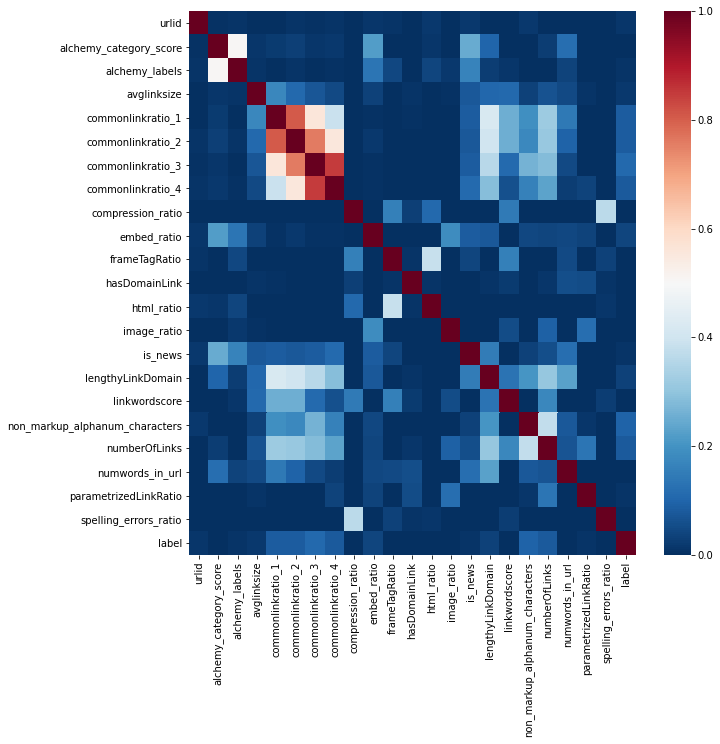

In [85]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(),cmap='RdBu_r', vmin=0)
plt.show()

In [86]:
px.histogram(train, x='alchemy_category', color="label", barmode='group')

## Text EDA

In [88]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

download_file_from_google_drive('1KfiHaW7Ei31VSmi7gqfSdegTjHB8xuAm', '/content/glove.840B.300d.zip')

In [174]:
def load_embed(file):
  '''
  Loads GLoVe embeddings
  file -> path to glove embeddings
  load_embed(...) -> Dict()
  '''
  def get_coefs(word,*arr): 
      return word, np.asarray(arr, dtype='float32')
  
  embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='utf-8'))
      
  return embeddings_index

# Build vocab from dataset
def build_vocab(texts):
  '''
  Creates a vocabulary from the given corpus
  texts -> pandas Series object
  build_vocab(...) -> Dict()
  '''
  sentences = texts.str.split().values
  vocab = {}
  for sentence in sentences:
      for word in sentence:
          try:
              vocab[word] += 1
          except KeyError:
              vocab[word] = 1
  return vocab

# Checks how many words present in embeddings wrt dataset
def check_coverage(vocab, embeddings_index):
  '''
  Checks the vocabulary from the given corpus with GLoVE data
  Returns out of vocabulary words from corpus that are not present in GLoVE data
  '''
  known_words = {}
  unknown_words = {}
  nb_known_words = 0
  nb_unknown_words = 0
  for word in vocab.keys():
      try:
          known_words[word] = embeddings_index[word]
          nb_known_words += vocab[word]
      except:
          unknown_words[word] = vocab[word]
          nb_unknown_words += vocab[word]
          pass

  print('Found embeddings for {:.3%} of vocab'.format(len(known_words) / len(vocab)))
  print('Found embeddings for  {:.3%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
  unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]
  unknown_words = pd.DataFrame(unknown_words,columns=['Word','Count'])
  return unknown_words

In [175]:
# !unzip /content/glove.840B.300d.zip
glove = load_embed("/content/glove.840B.300d.txt")

In [176]:
vocab = build_vocab(final['raw_text'])
oov_glove = check_coverage(vocab, glove)

Found embeddings for 76.846% of vocab
Found embeddings for  98.945% of all text


In [178]:
oov_glove

Word  Count
0                                             terminal01    392
1                                         InsidersHealth    204
2                                                 mjs538    163
3                                              videoPath    150
4                                             initHeight    125
5                                              initWidth    125
6                                         insidershealth    109
7                                         membernickname    100
8                                             defaultDiv     93
9                                                   281t     88
10                                                 divId     75
11                                                DCSext     73
12                                                wtargs     72
13                                                 gavon     72
14                                             pictureId     72
15                                                dcZone     70
16                                          ashleybaccam     69
17                                               burnred     66
18                                            1898374577     66
19                                                 web04     64
20                                            2004700022     63
21                                        brkrefFlashvar     60
22                                            bChannelId     58
23                                                   4t5     56
24                                                daves4     54
25                                                 72KY7     54
26                                               explosm     54
27                                       collegefootball     50
28                                          defaultDivHD     50
29                                                 cmtId     50
30                                                vidURL     50
31                                        expressinstall     50
32                                              embedSWF     50
33                                           bCategoryId     50
34                                            EncStyleID     50
35                                               styleid     50
36                                            IsLoggedIn     50
37                                                 dcOrd     50
38                                               dcHpcdp     50
39                                             dcChannel     50
40                                             useInPlay     50
41                                           callForInfo     50
42                                          sDescription     50
43                                   sGlobalContentTitle     50
44                                             sVidTitle     50
45                                      sGlobalContentID     50
46                                            iContentID     50
47                                       EmbedSEOLinkURL     50
48                                  EmbedSEOLinkKeywords     50
49                                                 sLink     50
50                                                 1half     50
51                                                 adnum     49
52                                         contentdetail     48
53                                                 domEl     47
54                                            SeanThomas     47
55                                            useNokeena     47
56                                        apexTagKeyVals     46
57                                                 dcMar     46
58                                             womansday     45
59                                             skattesok     44
60                                       bMaturityRating     44
61                                            dcNickname     44
62                  